In [2]:
import pandas as pd
import re
import struct
import matplotlib.pyplot as plt

In [3]:
def parse_wf_from_binary(filename):
    data_list = []
    nlines=0
    nevents=2000
    with open(filename, "rb") as f:
        while True:
            # Read the header                                                                                                                                                                                                                    
            data = f.read(4)  # Read uint32_t EVID                                                                                                                                                                                               
            if not data:
                break
            EVID = struct.unpack("<I", data)[0]
            data = f.read(8)  # Read uint64_t T                                                                                                                                                                                                  
            if not data:
                break
            T = struct.unpack("<Q", data)[0]
            data = f.read(4)  # Read uint32_t size                                                                                                                                                                                               
            if not data:
                break
            size = struct.unpack("<I", data)[0]
            data = f.read(8)  # Read uint64_t sampl_time                                                                                                                                                                                         
            if not data:
                break
            sampl_time = struct.unpack("<Q", data)[0]
            data = f.read(4)  # Read uint32_t ch (number of channels)                                                                                                                                                                            
            if not data:
                break
            ch = struct.unpack("<I", data)[0]
            waveform_data = {}
            # Read waveforms for each channel                                                                                                                                                                                                    
            for channel in range(ch):
                data = f.read(2)  # Read uint16_t numch                                                                                                                                                                                          
                if not data:
                    break
                numch = struct.unpack("<H", data)[0]
                channel_waveforms = []
                for _ in range(size):
                    data = f.read(4)  # Read float w                                                                                                                                                                                             
                    if not data:
                        break
                    w = struct.unpack("<f", data)[0]
                    channel_waveforms.append(w)
                waveform_data[f'{numch}'] = channel_waveforms
            # Create a row per sample point with all channels aligned                                                                                                                                                                            
            for i in range(size):
                row = {}

                row.update({f'CH{j+1}': waveform_data[f'{numch}'][i]/1e3 for j,numch in enumerate(waveform_data)})
                row.update({"event": EVID})
                row.update({"event_time": T})

                data_list.append(row)

    print(nlines,nevents)
    df = pd.DataFrame(data_list)
    df.insert(0, 'TIME', (df.index % size + 1) * sampl_time/1e9)  # Time in microseconds                                                                                                                                                         
    return df


In [8]:
run_dir = "/data/marian/cigar/runs/20250620_ArXe_3.5bar_no_source_6deg_Autotrg"
df = parse_wf_from_binary(f"{run_dir}/Acq_dig2-192.168.0.254_20250620103237-08.bin")

0 2000


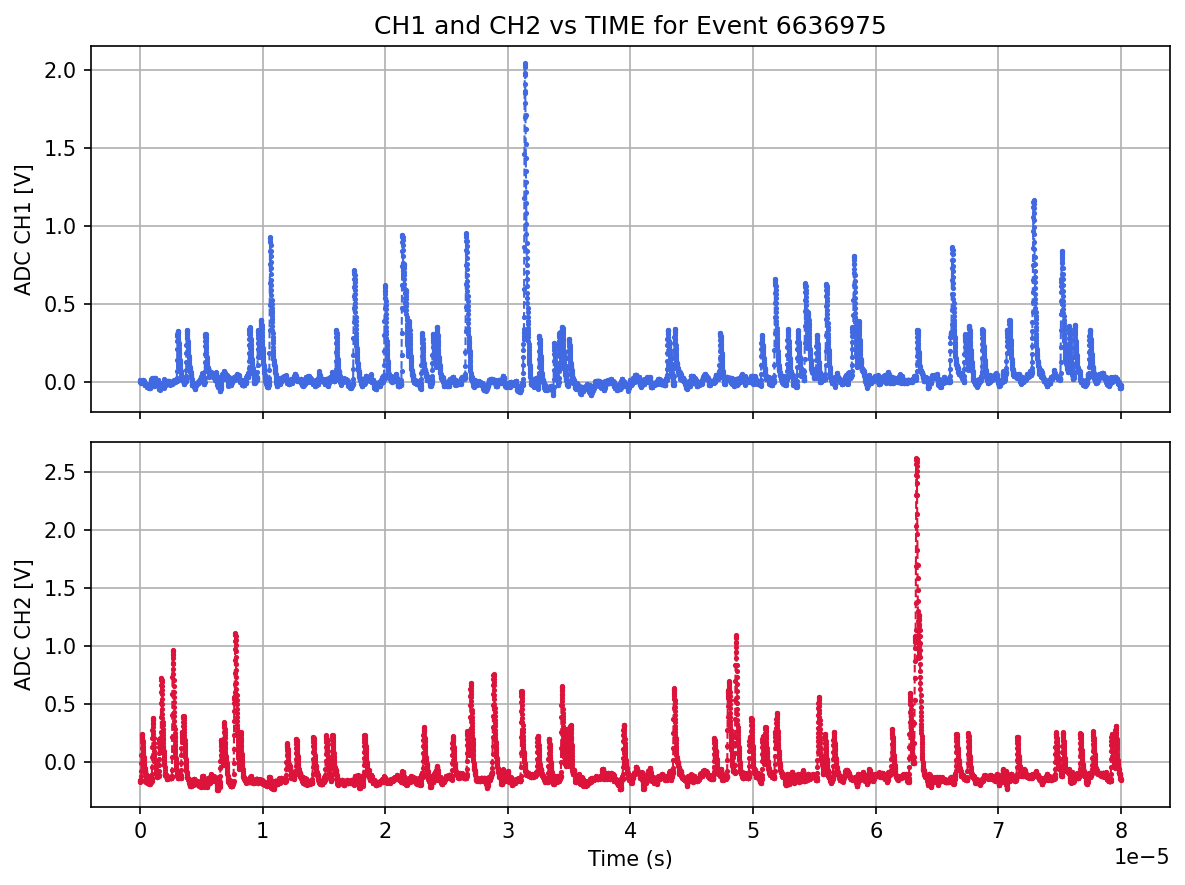

In [26]:
# Filter for a specific event (change index as needed)
event_list = df['event'].unique()
df_event = df[df['event'] == event_list[2]]  # Change the index to choose different event

# Create subplots: 2 rows, 1 column
fig, axs = plt.subplots(2, 1, figsize=(8, 6), dpi=150, sharex=True)

# Plot CH1
axs[0].plot(df_event['TIME'], (df_event['CH1']-df_event[df_event['TIME']<2e-7]['CH1'].mean()), marker='.', linestyle='--',
            color='royalblue', markersize=3, linewidth=1, label='CH1')
axs[0].set_ylabel('ADC CH1 [V]')
axs[0].set_title(f'CH1 and CH2 vs TIME for Event {event_list[5]}')
axs[0].grid(True)

# Plot CH2
axs[1].plot(df_event['TIME'], (df_event['CH2']-df_event[df_event['TIME']<2e-7]['CH2'].mean()), marker='.', linestyle='--',
            color='crimson', markersize=3, linewidth=1, label='CH2')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('ADC CH2 [V]')
axs[1].grid(True)

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()